In [91]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm

In [2]:
RANDOM_SEED = 214
np.random.seed(RANDOM_SEED)
az.style.use('arviz-white')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False",});

<center><img src="img/logo_inst.png" width="700">
<br>
<br>
<br>
<br>
<h1 align="center">Análisis exploratorio de modelos Bayesianos</h1> 
<h2 align="center">Comparación de modelos</h2>



<br>
<br>
<br>
<br>
<br>

## ArviZ: Análisis exploratorio de modelos Bayesianos

<br>
<br>
<center><img src="img/logo_arviz.png" width=500></center>
<br>

* <font color = "gray"> Diagnosticar la calidad de la inferencia </font>
* <font color = "gray"> Criticar a los modelos, incluyendo la evaluación de los supuestos del modelo y de sus predicciones </font>
* Comparación de modelos, incluyendo la selección y promediado de modelos
* <font color = "gray"> Preparar los resultados para una audiencia particular </font>

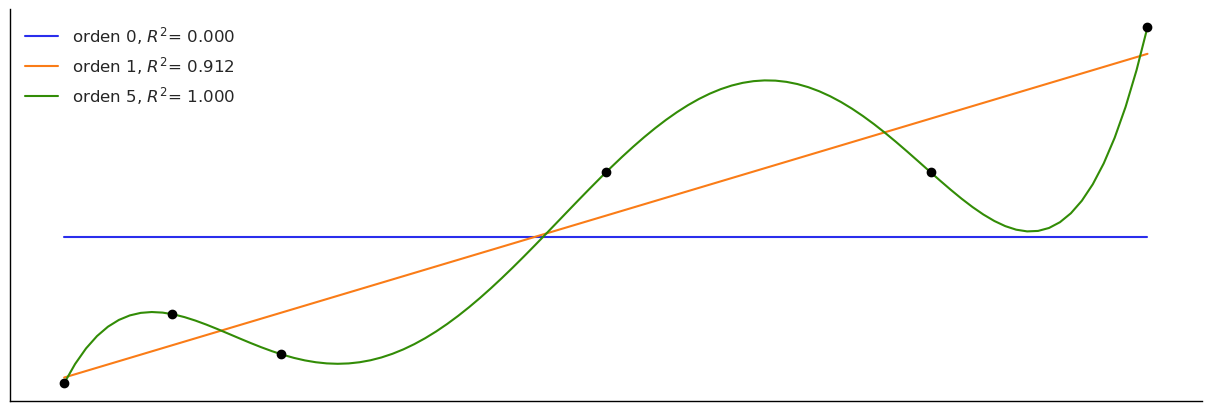

In [5]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))


x0 = np.array([4., 5., 6., 9., 12, 14.])
y0 = np.array([4.2, 6.1, 5., 10., 10, 14.])

order = [0, 1, 5]
ax.plot(x0, y0, 'ko', zorder=3)


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)
    ss_regression = np.sum((yhat-y0)**2)
    ss_total = np.sum((ybar-y0)**2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, p(x_n), label=f'orden {i}, $R^2$= {r2:.3f}')

    
ax.legend(loc=2, fontsize=12);

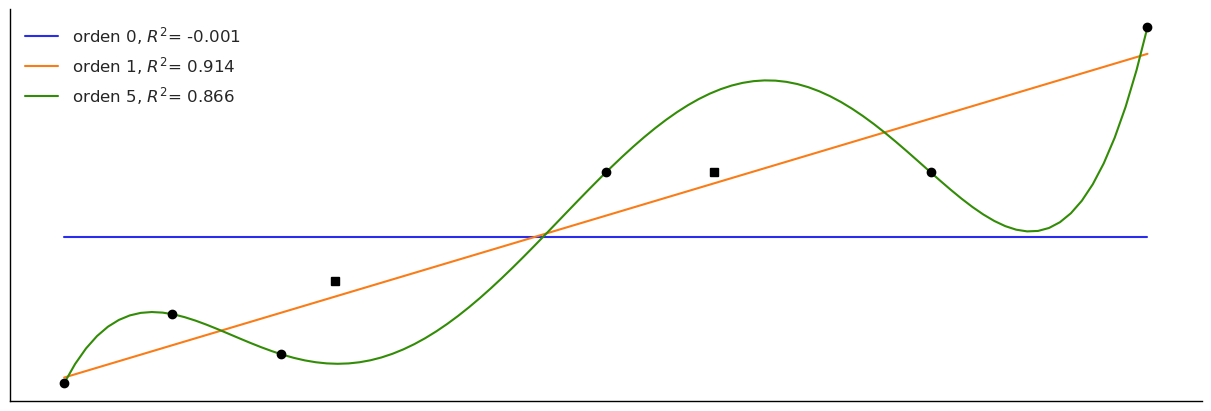

In [6]:
_, ax = plt.subplots( figsize=(12, 4))
x_ = np.array([6.5, 10])
y_ = np.array([7, 10])

ax.plot(x0, y0, 'ko', zorder=3)
ax.plot(x_, y_, 'ks', zorder=3)

ax.set_yticks([])
ax.set_xticks([])

x1 = np.concatenate((x0, x_))
y1 = np.concatenate((y0, y_))

for idx, i in enumerate(order):
    yhat = ps[idx](x1)
    ybar = np.mean(y1)
    ss_regression = np.sum((yhat-y1)**2)
    ss_total = np.sum((ybar-y1)**2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, ps[idx](x_n), label=f'orden {i}, $R^2$= {r2:.3f}')

    
ax.legend(loc=2, fontsize=12);

## Medidas de precisión predictiva


<br>

* **precisión dentro de la muestra**: la exactitud medida con los datos utilizados para ajustar un modelo


* **precisión fuera de la muestra** (o exactitud predictiva): la exactitud del modelo medido con datos no utilizados para ajustar el modelo



* Si solo usamos la exactitud dentro de la muestra podríamos pensar que tenemos un modelo mejor de lo que realmente es


## Medidas de precisión predictiva

<br>

* Utilizar la precisión fuera de la muestra, requiere dejar de lado una porción de los datos durante el ajuste, y usar esa porción solo para la evaluación. Esto suele ser un lujo.


* Alternativas:
     * Validación cruzada
     * Criterios de información

## Criterios de información


* Los criterios de información estiman la precisión fuera de la muestra a partir de la precisión dentro de la muestra

* El AIC es un criterio de información muy conocido y ampliamente utilizado, especialmente fuera del mundo Bayesiano. Se define como:

$$AIC = -2 \underbrace{\sum_{i}^{N} \log p(y_i \mid \hat{\theta}_{mle})}_{\text{bondad ajuste}} + \overbrace{\; 2 k \;
}^{\text{penalización}} $$

Donde
* $\hat {\theta}_{mle}$ es una estimación puntual, la suma se realiza sobre las $N$ observaciones

* $k$ es la cantidad de parámetros del modelo.

## Validación cruzada (crossvalidation, CV)

<br>


* Existen muchas [variantes](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), pero de forma general...


* Dado un conjunto de datos lo dividimos en 2 grupos

* Un grupo lo usamos para entrenar/ajustar el modelo (train)

* El otro para evaluar el ajuste (test)


## k-fold-CV

<br>

* Dividimos los datos en k-grupos (sin repetir datos) los usamos para ajustar el modelo k-veces

<br>


<center><img src="img/KfoldCV.gif" width=600></center>


## LOO-CV

<br>

* Si k=1 entonces tenemos leave-one-out-CV. Hay que ajustar el modelo tantas veces como datos tengamos

<br>


<center><img src="img/LOOCV.gif" width=500></center>


## Leave-One-Out-Cross-Validation

<br>


$$
\text{ELPD}_\text{LOO-CV} = \sum_{i=1}^{n} \log
    \int \ p(y_i \mid \boldsymbol{\theta}) \; p(\boldsymbol{\theta} \mid y_{-i}) d\boldsymbol{\theta}
$$

$$
\sum_{i}^{n} \log
    \left(\frac{1}{s}\sum_j^s \ \color{#E9692C}{p(y_i \mid \boldsymbol{\theta_{-i}^j})} \right)
$$


* Es posible aproximar $\color{#E9692C}{p(y_i \mid \boldsymbol{\theta_{-i}^j})}$ usando un método llamado Pareto-Smooth-Importance-Sampling

## Regresión polinomial

<br>

* Vamos a generar un conjunto de datos sintéticos.

* La relación real será lineal

* Queremos comparar dos modelos
    * regresión lineal (polinomio grado 1)
    * regresión cúbica (polinomio grado 3)


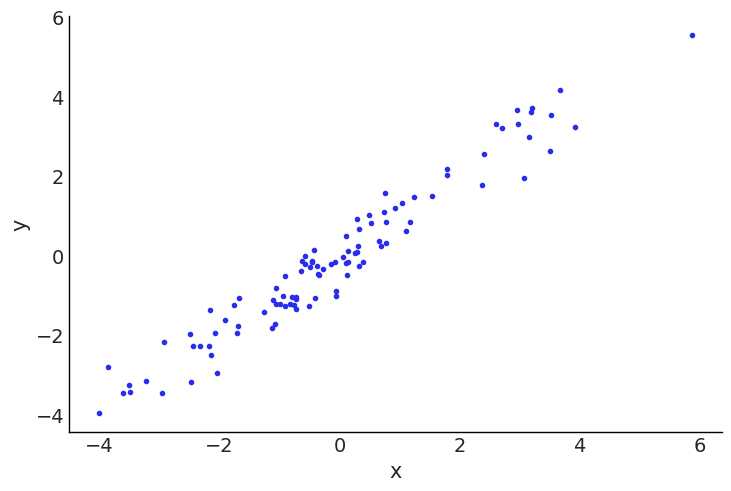

In [24]:
x = np.random.normal(0, 2, 100)
y = np.random.normal(x, 0.5)
plt.plot(x, y, ".")
plt.ylabel("y")
plt.xlabel("x");

In [8]:
with pm.Model() as modelo_l:
    α = pm.Normal("α", 0, 1)
    β = pm.Normal("β", 0, 1)

    μ = pm.Deterministic("μ", α + β * x)
    σ = pm.HalfNormal("σ", 1)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y)

    idata_l = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [9]:
with pm.Model() as modelo_p:
    α = pm.Normal("α", 0, 1)
    β = pm.Normal("β", 0, 1, shape=3)

    μ = pm.Deterministic("μ", α +  β[0] *x +  β[1] *x**2 +  β[2] *x**3)
    σ = pm.HalfNormal("σ", 1)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y)

    idata_p = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [10]:
models_dict = {"modelo_l": idata_l, "modelo_p": idata_p}
cmp = az.compare(models_dict)
cmp

/home/osvaldo/anaconda3/envs/mol_bayes/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
modelo_l,0,-71.696114,2.584367,0.000000,1.0,6.619594,0.000000,False,log
modelo_p,1,-73.248722,3.737823,1.552608,0.0,6.466409,0.685413,True,log


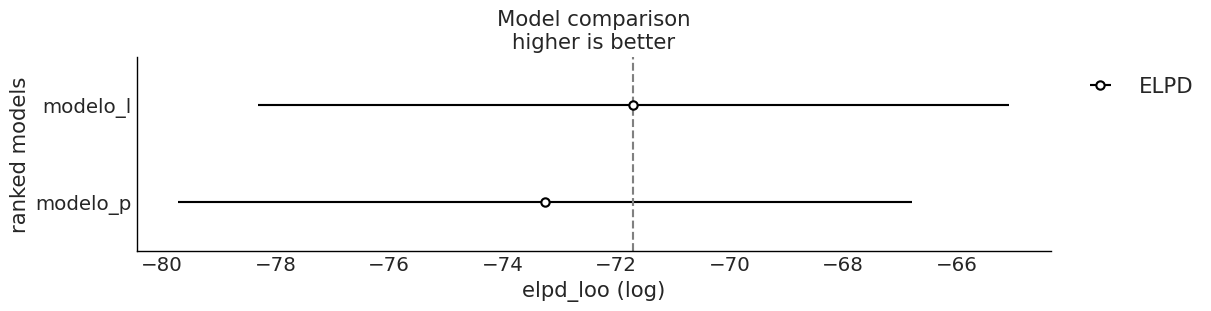

In [11]:
az.plot_compare(cmp, figsize=(12, 3),  plot_ic_diff=False);

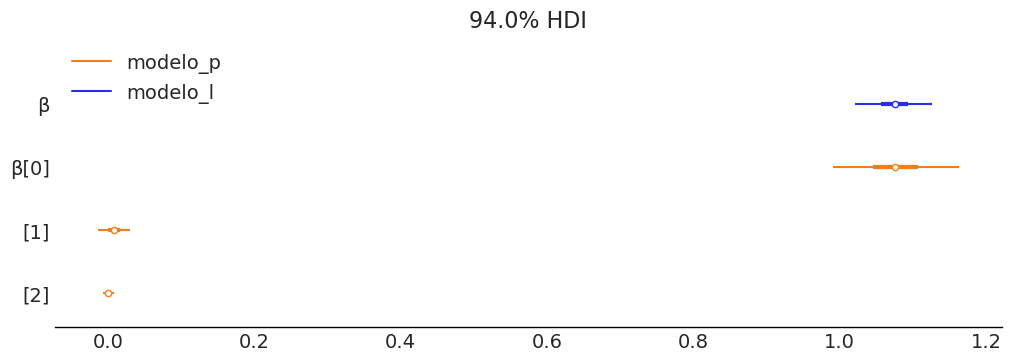

In [12]:
az.plot_forest(list(models_dict.values()), model_names=list(models_dict.keys()), figsize=(10, 3.5), combined=True, var_names=["β"]);

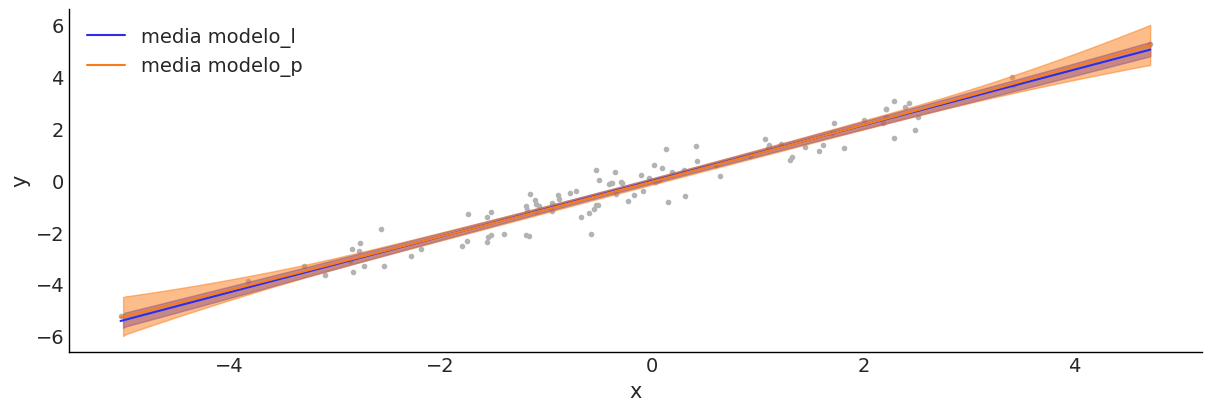

In [22]:
_, ax = plt.subplots(figsize=(12, 4))
plt.plot(x, y, ".", color="0.7", zorder=1)
idx = np.argsort(x)

for (model, idata), c in zip(models_dict.items(), ["C0", "C1"]):
    ax.plot(x[idx], idata.posterior["μ"].sel({"μ_dim_0":idx}).mean(("chain", "draw")), color=c, label=f"media {model}");
    az.plot_hdi(x, idata.posterior["μ"], color=c)
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.legend();

## Tratamiento antifúngico

<br>

* Algunos hongos pueden reducir el crecimiento de plantas

* Queremos saber la diferencia en el crecimiento bajo diferentes tratamientos antifúngicos del suelo

* Las plantas se siembran, se dejan brotar y se miden sus alturas

* Luego se aplican diferentes tratamientos al suelo

* Tenemos cuatro variables de interés: altura inicial (h0), altura final (h1), tratamiento y presencia de hongos


<br>

Adaptado de [Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/)

In [26]:
N = 126  # número de plantas
h0 = np.random.normal(10, 2, N)  # alturas iniciales
tratamiento = np.repeat([0, 1], N / 2)  # asignamos tratamiento
hongo = np.random.binomial(n=1, p=0.5 - tratamiento * 0.4, size=N)  # presencia del hongo
h1 = h0 + np.random.normal(5 - 3 * hongo, size=N)  # crecimiento
d = pd.DataFrame({"h0": h0, "h1": h1, "tratamiento": tratamiento, "hongo": hongo})

* We know that the plants at time t = 1 should be taller than at time t = 0.
* We can then think of the final height in terms of proportions of the inital height 
* If h0 is the inital height and h1 is the final high, then p = h1/h0 is the proportion that the plante crecio
    * If p = 1 la planta creció
    * If p = 2 la planta duplicó su tamaño

* Prior centrado en 1 que permite valores más bajos (la planta murió/revivio)
* Prior positivo
* Duplicar el crecimiento es poco probable
* So this prior expects anything from ~40% shrinkage up to ~50% growth.

Lognormal(mean=1.03, median=1.0, std=0.26, lower=0.62, upper=1.6)

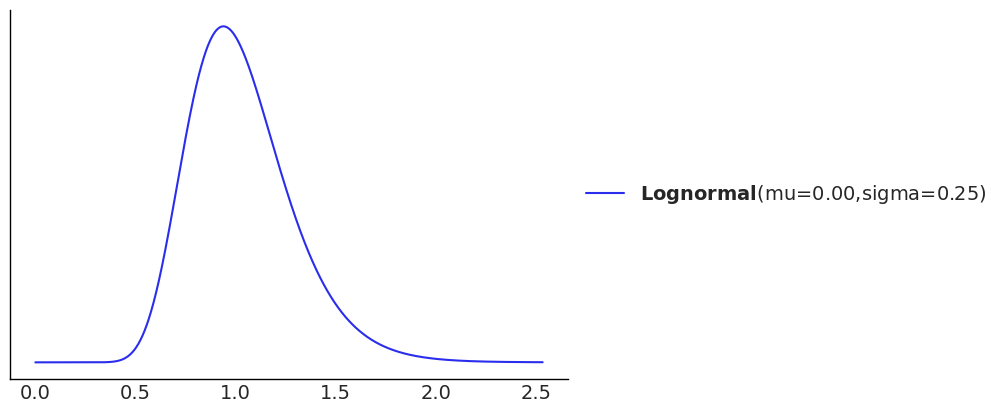

In [8]:
dist = pz.LogNormal(0, 0.25)
dist.plot_pdf()
dist.summary()

In [9]:
with pm.Model() as modelo_p:
    p = pm.Lognormal("p", 0, 0.25)

    μ = pm.Deterministic("μ", p * d.h0)
    σ = pm.Exponential("σ", 1)

    h1 = pm.Normal("h1", mu=μ, sigma=σ, observed=d.h1)

    idata_p = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Ahora hacemos un modelo lineal que incluye la variable `tratamiento`

* Vamos a seguir pensando en términos de proporciones, solo que ahora p es una función lineal de tratamiento

* Los prior sobre los coeficientes del modelo lineal implican un prior similar al que previamente teníamos.

In [10]:
with pm.Model() as modelo_plt:
    α = pm.Normal("α", 0, 0.3)
    β = pm.Normal("β", 0, 0.5)

    p = pm.Deterministic("p", α + β * d.tratamiento)

    μ = pm.Deterministic("μ", p * d.h0)
    σ = pm.Exponential("σ", 1)

    h1 = pm.Normal("h1", mu=μ, sigma=σ, observed=d.h1)

    idata_plt = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Ahora hacemos un modelo lineal que incluye la variable `tratamiento` y `hongo`

In [11]:
with pm.Model() as modelo_plth:
    α = pm.Normal("α", 0, 0.3)
    β = pm.Normal("β", 0, 0.5, shape=2)

    p = pm.Deterministic("p", α + β[0] * d.tratamiento + β[1] * d.hongo)

    μ = pm.Deterministic("μ", p * d.h0)
    σ = pm.Exponential("σ", 1)

    h1 = pm.Normal("h1", mu=μ, sigma=σ, observed=d.h1)

    idata_plth = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [99]:
cmp = az.compare({"modelo_p": idata_p,
                  "modelo_plt": idata_plt,
                  "modelo_plth": idata_plth})
cmp.round(2)

NameError: name 'idata_plt' is not defined

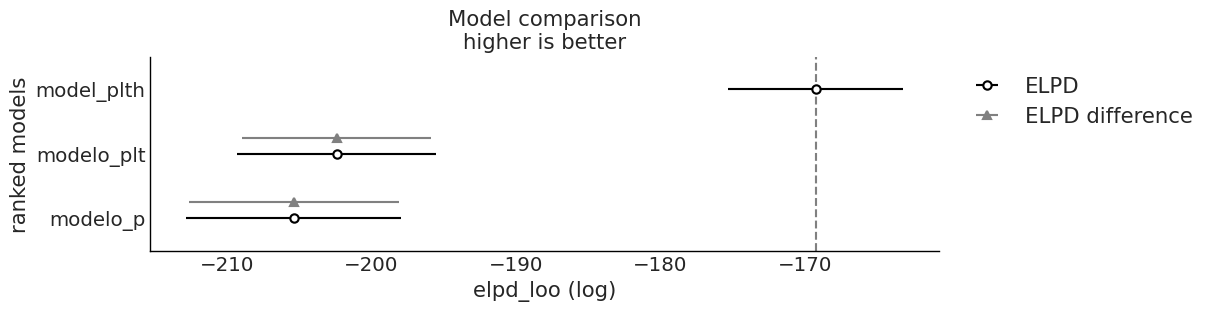

In [13]:
az.plot_compare(cmp, figsize=(12, 3),  plot_ic_diff=False);

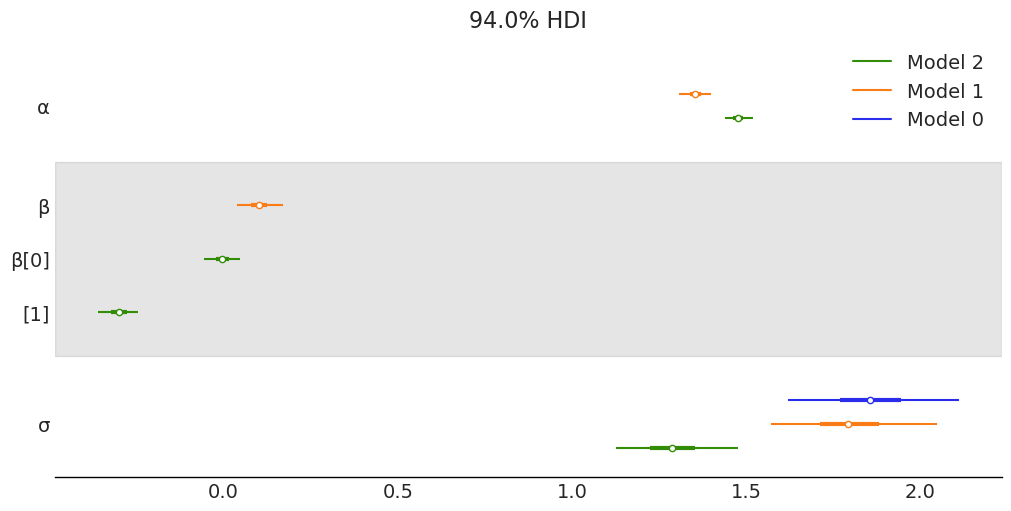

In [14]:
idatas = [idata_p, idata_plt, idata_plth]
az.plot_forest(idatas, figsize=(10, 5), combined=True, var_names=["~p", "~μ"]);

## Interpretando la comparación

* elpd_loo: contiene los valores de LOO
* p_loo: el *número efectivo de parámetros* (no lo tomen demasiado en serio)
* elpd_diff: la diferencia relativa entre el valor de LOO para el modelo mejor clasificado y el valor de LOO para cada modelo
* weight: peso relativo (o probabilidad) de cada modelo (dentro de los modelos comparados)
* se: el error estándar de LOO
* dse: el error estándar de las diferencias entre el valor de LOO para el modelo mejor clasificado y el valor de LOO para cada modelo.
* warning: indica que el cálculo de LOO puede no ser confiable
* scale: indica la escala usada para reportar los valores de LOO. La escala usada por defecto es 
`log`, valores más grandes de loo indican mejores modelos.

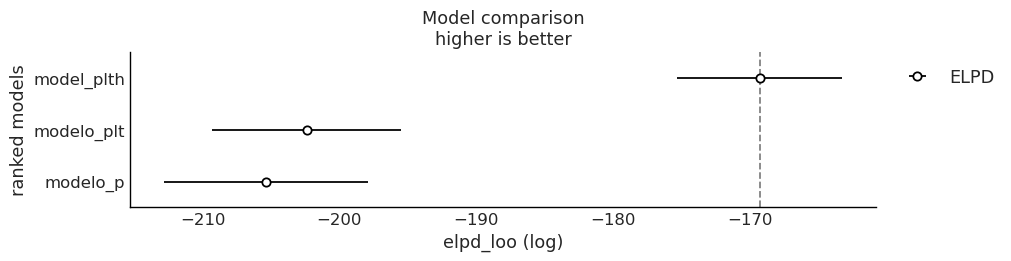

In [15]:
az.plot_compare(cmp, insample_dev=False, plot_ic_diff=False, figsize=(10, 2.5));

## Factores de Bayes (FB)

<br>

* Los factores de Bayes suelen aparecer en la literatura como una alternativa Bayesiana al contraste de hipótesis frecuentista 

* El uso de los FB suele ser una divisoria de aguas
    * Algunas razones son "técnicas" (ya las veremos)
    * Otras son metodologicas. En general es ás util hacer inferencia y estimar el "tamaño del efecto" que comparar hipótesis 

## Factores de Bayes

Reescribamos el teorema de Bayes, haciendo explícita la dependencia de la inferencia en un modelo dado $ M $:

$$p(\theta \mid y, M_k) = {\frac {p(y \mid \theta, M_k)p(\theta \mid M_k)}{p(y \mid M_k)}}$$

El término en el denominador se conoce como marginal likelihood, el cociente entre dos likelihood marginales se conoce como factor de Bayes:

$$FB = \frac{p(y \mid M_0)}{p(y \mid M_1)}$$

* cuando FB > 1, el modelo 0 explica los datos mejor que el modelo 1

* Usar $p(y \mid M_k)$ para comparar modelos está bien si todo los **modelos** tienen la misma probabilidad a priori.

* Caso contrario tenemos que calcular los _posterior odds_:

$$\underbrace{\frac{p(M_0 \mid y)}{p(M_1 \mid y)}}_\text{posterior odds} = \underbrace{\frac{p(y \mid M_0)}{p(y \mid M_1)}}_\text{Bayes factors} \, \underbrace{\frac{p(\ M_0 \ )}{p(\ M_1 \ )}}_\text{prior odds}$$

## Algunos comentarios sobre los factores de Bayes


$$p(y \mid M_k) = \int_{\theta_k} p(y \mid \theta_k, M_k) p(\theta_k, M_k) d\theta_k$$


* Lo bueno: los modelos con más parámetros tienen una penalización mayor que los modelos con menos parámetros. La razón intuitiva es que cuanto mayor sea el número de parámetros, mayor será la dispersión del prior respecto del likelihood

* Lo malo: calcular la probabilidad marginal es, en general, una tarea difícil porque es una integral de una función altamente variable en un espacio de parámetros de alta dimensión.

* Lo feo: la probabilidad marginal depende *sensiblemente* de los valores del prior

* Una forma relativamente simple de calcular los factores de Bayes con PyMC es mediante el uso del método de inferencia Sequential Monte Carlo

In [104]:
y = np.repeat([1, 0], [50, 50])
priors = ((1, 1), (30, 30))

models = []
idatas = []
for alpha, beta in ((1, 1), (30, 30)):
    with pm.Model() as model:
        a = pm.Beta("a", alpha, beta)
        yl = pm.Bernoulli("yl", a, observed=y)
        idata = pm.sample_smc(random_seed=42)
        idata.extend(pm.sample_posterior_predictive(idata))
        idata.extend(pm.sample_prior_predictive())
        idatas.append(idata)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Sampling: [a]
Sampling: [a]
Sampling: [a]
Sampling: [a]
/home/osvaldo/anaconda3/envs/mol_bayes/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [yl]


Sampling: [a, yl]
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Sampling: [a]
Sampling: [a]
Sampling: [a]
Sampling: [a]
/home/osvaldo/anaconda3/envs/mol_bayes/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [yl]


Sampling: [a, yl]


In [105]:
BF_smc = np.exp(idatas[1].sample_stats["log_marginal_likelihood"].mean() -
                idatas[0].sample_stats["log_marginal_likelihood"].mean()
               )
np.round(BF_smc).item()

5.0

In [106]:
cmp = az.compare({"modelo_11": idatas[0],
                  "modelo_3030": idatas[1]})
cmp.round(2)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
modelo_3030,0,-69.95,0.64,0.00,1.0,0.01,0.00,False,log
modelo_11,1,-70.32,1.01,0.37,0.0,0.00,0.01,False,log


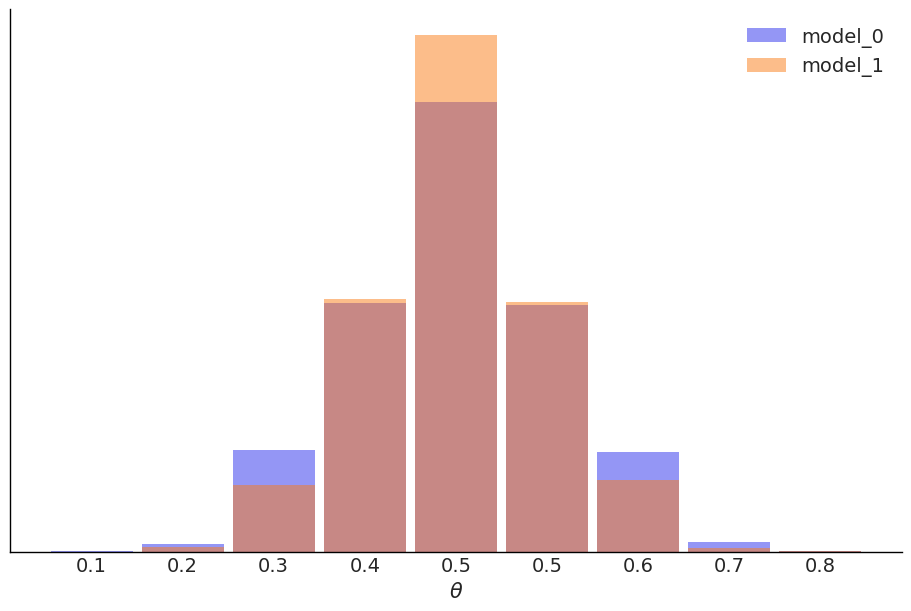

In [107]:
_, ax = plt.subplots(figsize=(9, 6))

bins = np.linspace(0.1, 0.9, 10)
ax = az.plot_dist(
    idata_BF_0.posterior_predictive["y"].mean("y_dim_2"),
    label="model_0",
    kind="hist",
    hist_kwargs={"alpha": 0.5, "bins": bins},
)
ax = az.plot_dist(
    idata_BF_1.posterior_predictive["y"].mean("y_dim_2"),
    label="model_1",
    color="C1",
    kind="hist",
    hist_kwargs={"alpha": 0.5, "bins": bins},
    ax=ax,
)
ax.legend()
ax.set_xlabel("$\\theta$")
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.1f"))
ax.set_yticks([]);

## Criterios de información vs Factores de Bayes

* El factor Bayes se centra en estimar cual modelo es _mejor_ (y el prior es parte del modelo)

* LOO (y criterios de información como AIC/WAIC) se centran en estimar qué modelo dará las _mejores_ predicciones (el prior se tienen en cuenta indirectamente)

## Savage-Dickey Density Ratio

* Existen casos en que la hipótesis nula es un caso particular de la hipótesis alternativa

* Está sesgada esta moneda? siendo $\theta=0.5$ el no-sesgo y cualquier otro valor de $\theta$ la alternativa
 
* En estos casos el cálculo del FB es más simple

$$
BF_{01} = \frac{p(y \mid H_0)}{p(y \mid H_1)} \frac{p(\theta=0.5 \mid y, H_1)}{p(\theta=0.5 \mid H_1)}
$$

AttributeError: module 'arviz' has no attribute 'plot_bf'

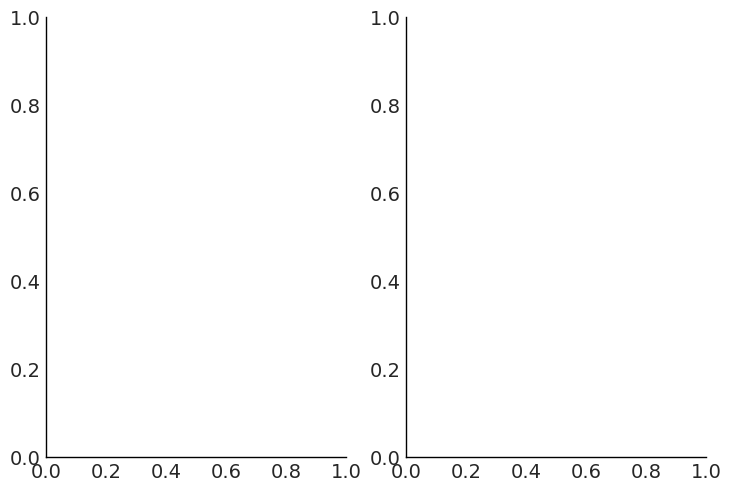

In [108]:
_, axes = plt.subplots(1, 2)
az.plot_bf(idatas[0], var_name="a", ref_val=0.5, ax=axes[0]);
az.plot_bf(idatas[0], var_name="a", ref_val=0.5, ax=axes[1]);

## Ejercicios

1. Explique porqué WAIC es más general que AIC. ¿Bajo que condiciones estos dos criterios son numéricamente similares?

1. ¿Cuál es la diferencia entre seleccionar modelos y promediar modelos?

1. Al comparar modelos usando criterios de información es necesario usar el mismo conjunto de datos. ¿Por qué? ¿Qué sucede si cambiamos la cantidad de datos?

1. ¿Cómo cambia el número efectivo de parámetros (medio por WAIC) a medida que el prior se concentra más?

1. ¿Cómo se vincula la respuesta anterior con el concepto de regularización y con el concepto de modelos jerárquicos? ¿Puede un prior reducir el overfitting? ¿Puede un prior favorecer el underfitting?

1. Calcule WAIC y BF para los modelos model_BF_0 y model_BF_1. Use (monedas = 30, caras = 9) y luego (monedas = 300, caras = 90). Compare las diferencias en términos de WAIC y BF al aumentar los datos.